# Air quality data of pearse street station, Dublin, Ireland

This dataset is taken from - https://airquality.ie/station/EPA-69

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as date
import math
import os
import warnings
warnings.filterwarnings('ignore')

**We have the entier 2022 year data in three seperate csv**

In [2]:
plot2 = pd.read_csv('../data/pearse_street/data-plot-21.csv')
plot3 = pd.read_csv('../data/pearse_street/data-plot-22.csv')
plot4 = pd.read_csv('../data/pearse_street/data-plot-23.csv')

## Data processing
Before moving forward, we make sure that all have the same columns present

In [3]:
plot2.head()

,Date and Time,NO<sub>2</sub>,O<sub>3</sub>,PM<sub>10</sub>,PM<sub>2.5</sub>
0,2022-01-01 00:00:00,14.53,41.67,NaN,NaN
1,2022-01-01 01:00:00,10.20,44.99,NaN,NaN
2,2022-01-01 02:00:00,7.72,49.98,NaN,NaN
3,2022-01-01 03:00:00,6.73,52.82,NaN,NaN
4,2022-01-01 04:00:00,2.87,57.84,NaN,NaN


In [4]:
plot3.head()

,Date and Time,NO<sub>2</sub>,O<sub>3</sub>,PM<sub>10</sub>,PM<sub>2.5</sub>
0,2022-07-01 01:00:00,21.00,24.46,7.10,3.39
1,2022-07-01 02:00:00,10.54,33.62,4.62,1.95
2,2022-07-01 03:00:00,10.73,30.87,4.20,2.05
3,2022-07-01 04:00:00,10.17,28.82,4.18,2.09
4,2022-07-01 05:00:00,15.18,24.48,4.92,2.34


In [5]:
plot4.head()

,Date and Time,NO<sub>2</sub>,O<sub>3</sub>,PM<sub>10</sub>,PM<sub>2.5</sub>
0,2022-12-01 00:00:00,66.61,-1.81,46.92,20.95
1,2022-12-01 01:00:00,60.84,-1.42,42.10,26.36
2,2022-12-01 02:00:00,54.61,-1.75,30.74,22.97
3,2022-12-01 03:00:00,54.87,-1.09,18.82,13.91
4,2022-12-01 04:00:00,49.75,-2.01,17.44,12.04


Combining the three datasets into a single dataframe

In [6]:
aqi_2022 = pd.concat([plot2,plot3,plot4], axis=0).reset_index()

Renaming columns and changing datatypes

In [7]:
aqi_2022 = aqi_2022.rename(columns={'Date and Time': 'datetime','NO<sub>2</sub>': 'no2','O<sub>3</sub>': 'o3' , 'PM<sub>10</sub>': 'pm10', 'PM<sub>2.5</sub>': 'pm2.5'})

In [8]:
aqi_2022['datetime'] = pd.to_datetime(aqi_2022['datetime'])

In [9]:
aqi_2022.dtypes

index                int64
datetime    datetime64[ns]
no2                float64
o3                 float64
pm10               float64
pm2.5              float64
dtype: object

In [10]:
aqi_2022.head()

,index,datetime,no2,o3,pm10,pm2.5
0,0,2022-01-01 00:00:00,14.53,41.67,NaN,NaN
1,1,2022-01-01 01:00:00,10.20,44.99,NaN,NaN
2,2,2022-01-01 02:00:00,7.72,49.98,NaN,NaN
3,3,2022-01-01 03:00:00,6.73,52.82,NaN,NaN
4,4,2022-01-01 04:00:00,2.87,57.84,NaN,NaN


## Visualising outliers

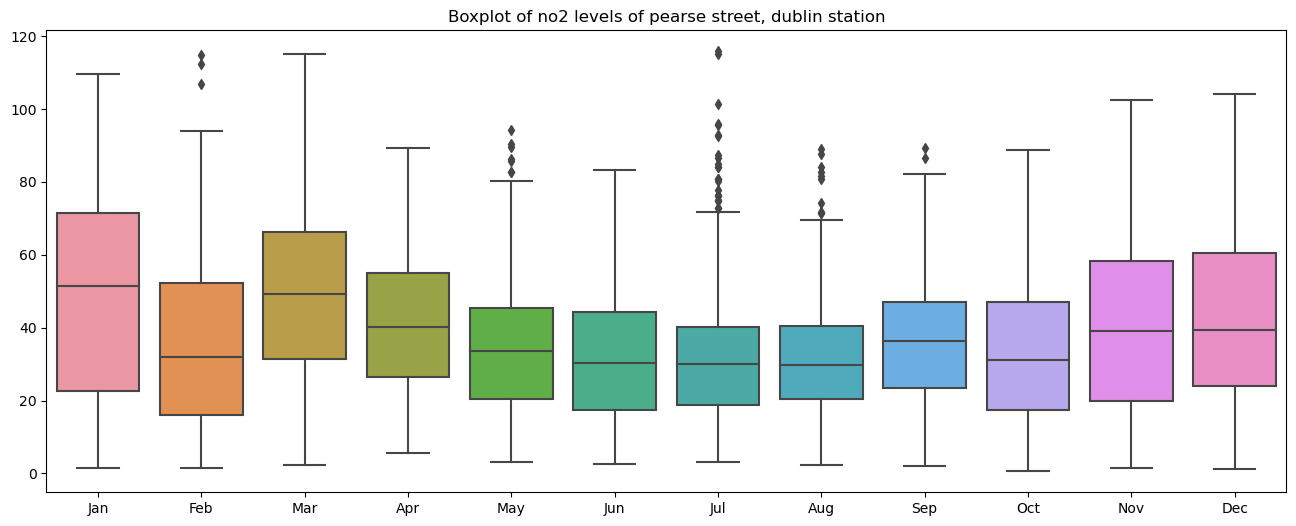

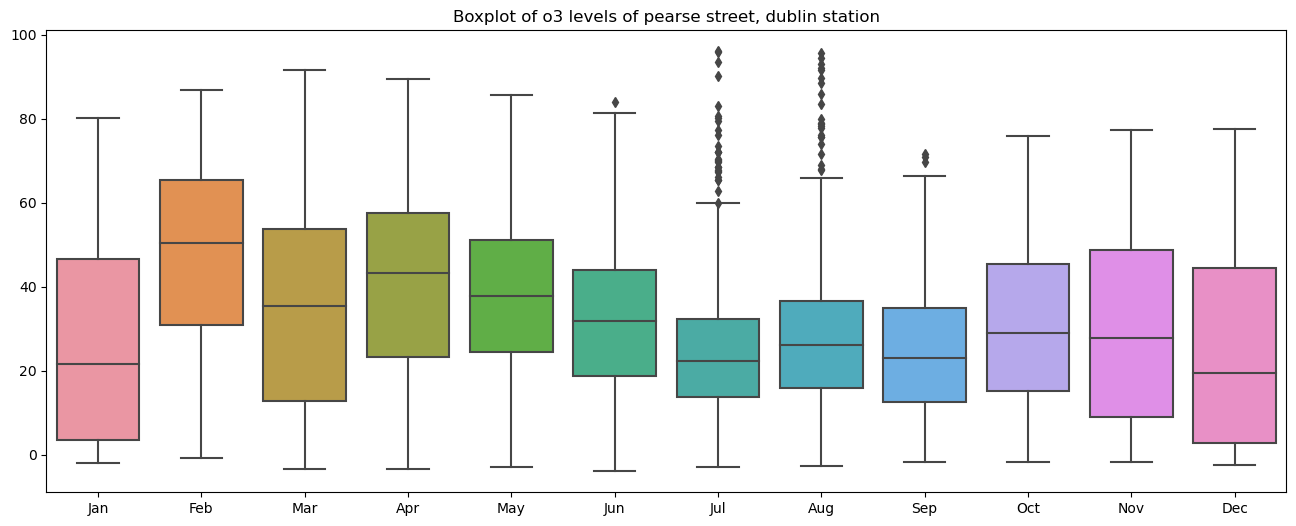

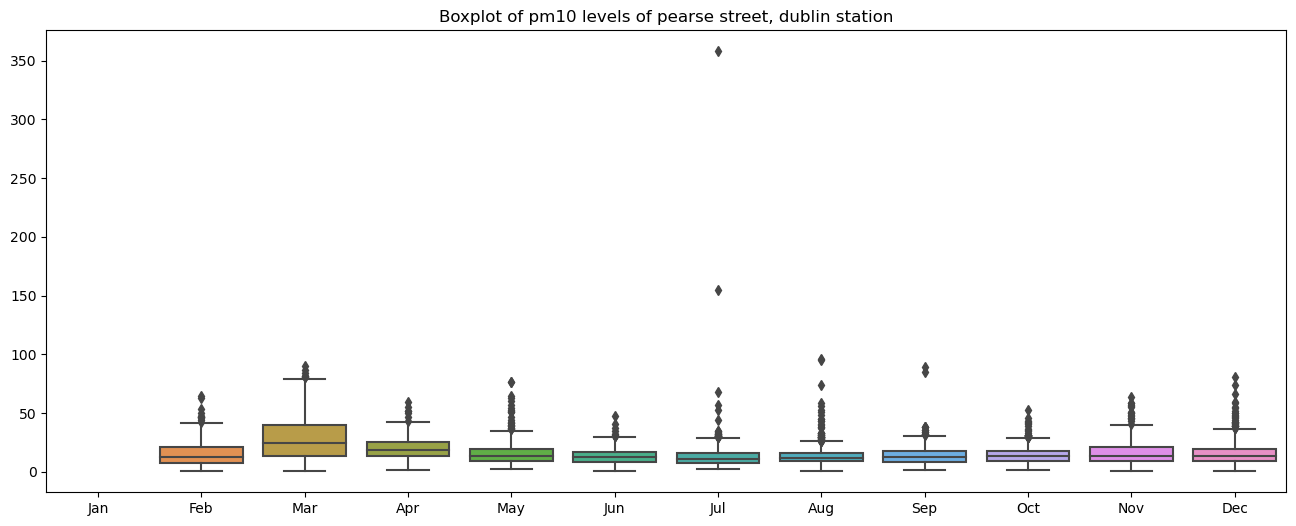

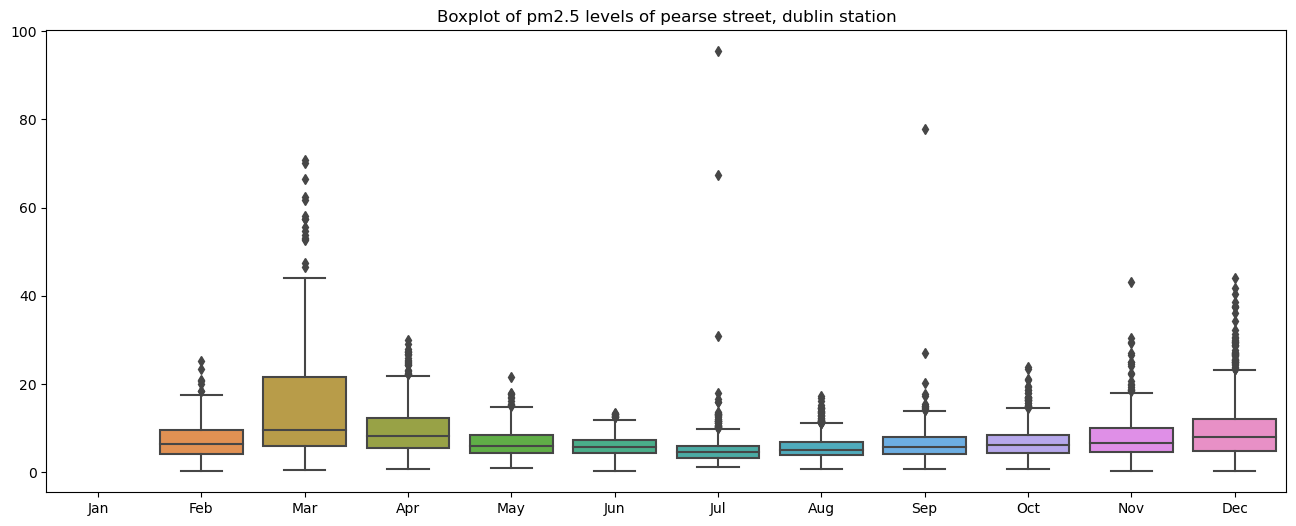

In [11]:
def plotbox(dataset, col, fromtime, to):
    timeframe = dataset[(dataset['datetime'] >= fromtime)
                         & (dataset['datetime'] <= to)]
    
    timeframe.loc[:, 'month'] = timeframe['datetime'].dt.strftime('%b')
    
    plt.figure(figsize=(16, 6))
    sns.boxplot(data=timeframe, x='month', y=col)
    plt.title("Boxplot of " + col +" levels of pearse street, dublin station")
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

plotbox(aqi_2022, 'no2','2022-01-01', '2022-12-31')
plotbox(aqi_2022, 'o3','2022-01-01', '2022-12-31')
plotbox(aqi_2022, 'pm10','2022-01-01', '2022-12-31')   
plotbox(aqi_2022, 'pm2.5','2022-01-01', '2022-12-31')     

## Visualising distribution

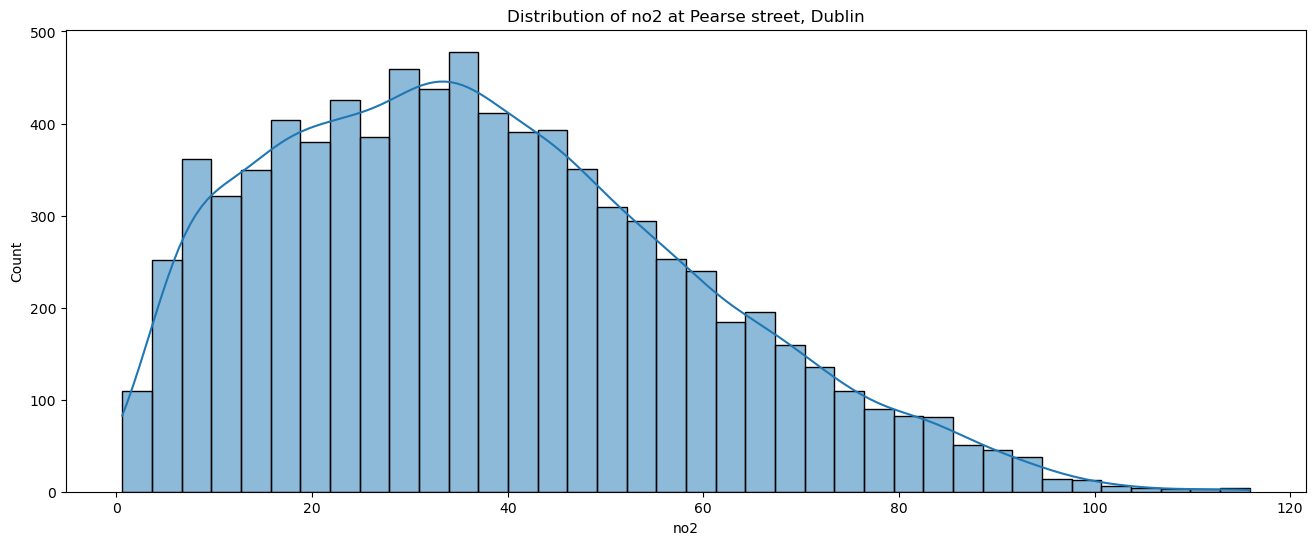

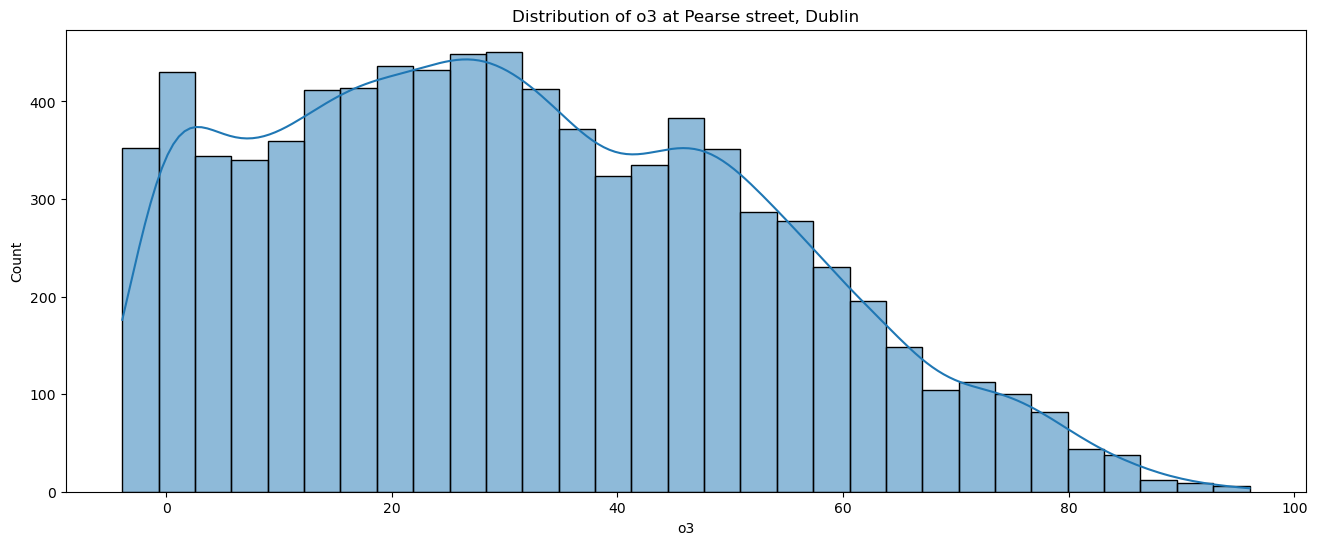

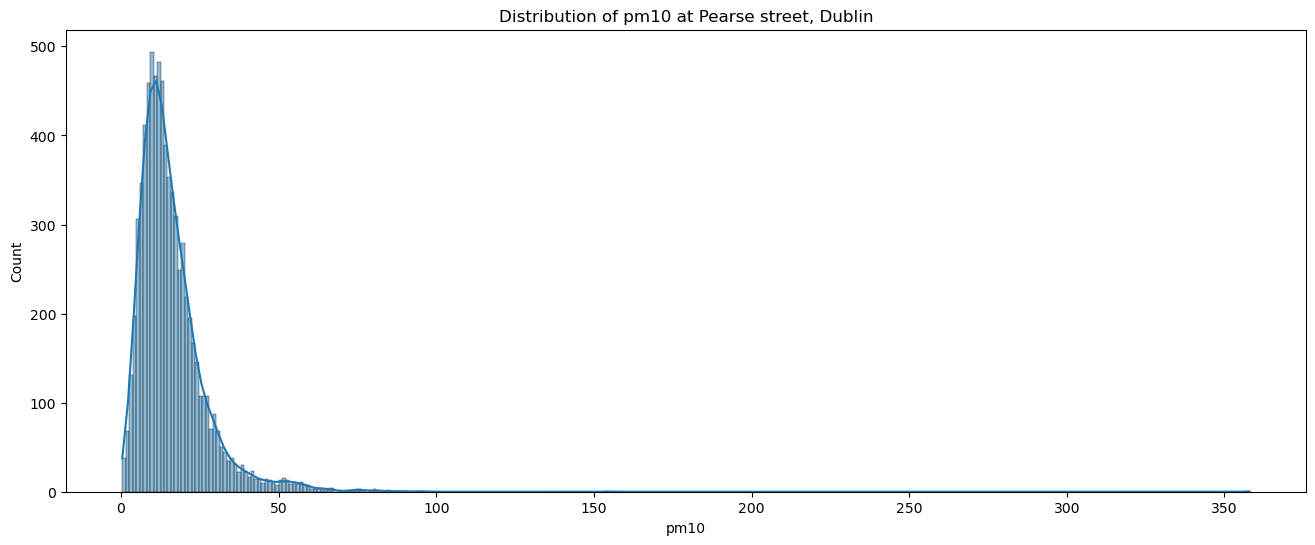

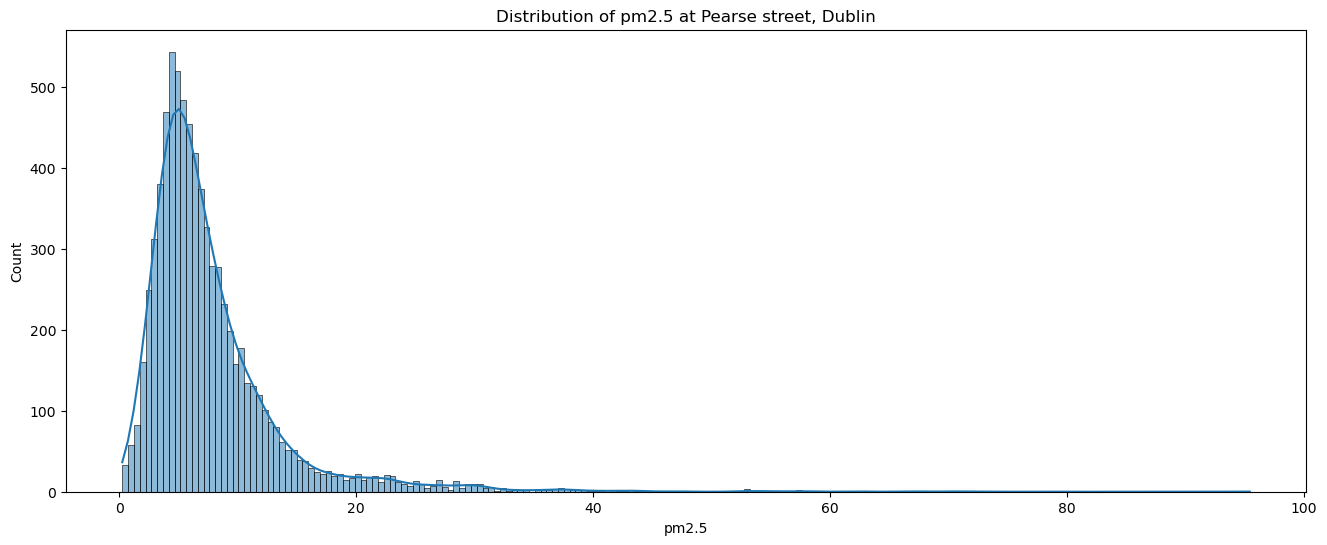

In [12]:
def plothistogram(dataset, col,fromtime, to, title):
    timeframe = dataset[(dataset['datetime'] >= fromtime)
                         & (dataset['datetime'] <= to)]
    
    plt.figure(figsize=(16, 6))
    sns.histplot(timeframe[col], kde=True)
    plt.title("Distribution of " + col + " at " + title)
    plt.show()
    

plothistogram(aqi_2022, 'no2', '2022-01-01', '2022-12-31', 'Pearse street, Dublin')
plothistogram(aqi_2022, 'o3', '2022-01-01', '2022-12-31', 'Pearse street, Dublin')
plothistogram(aqi_2022, 'pm10', '2022-01-01', '2022-12-31', 'Pearse street, Dublin')
plothistogram(aqi_2022, 'pm2.5', '2022-01-01', '2022-12-31', 'Pearse street, Dublin')

    

## Visualising trends

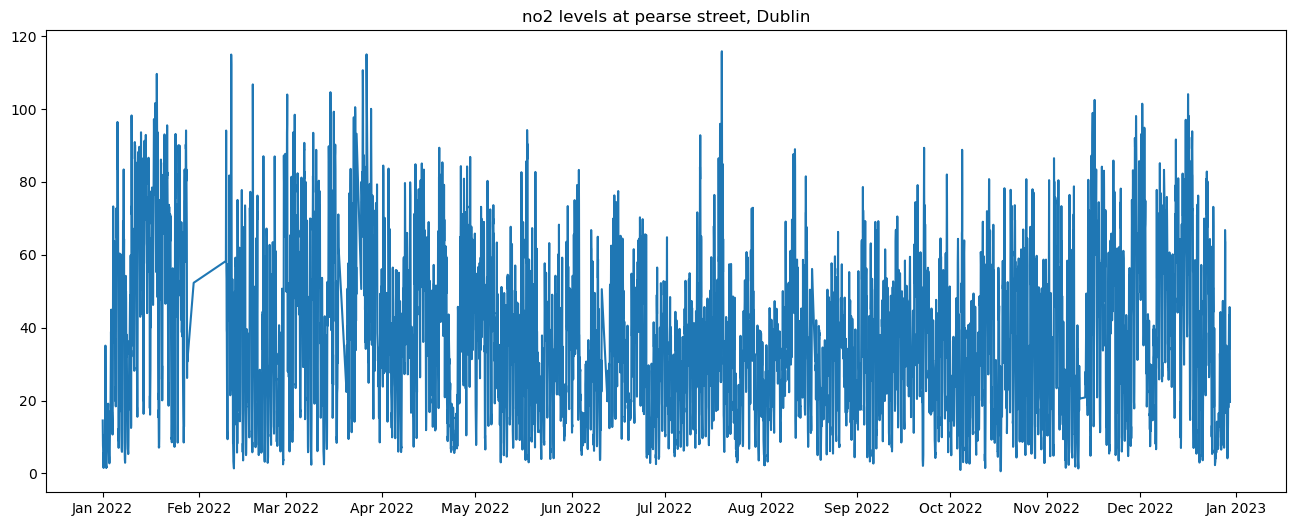

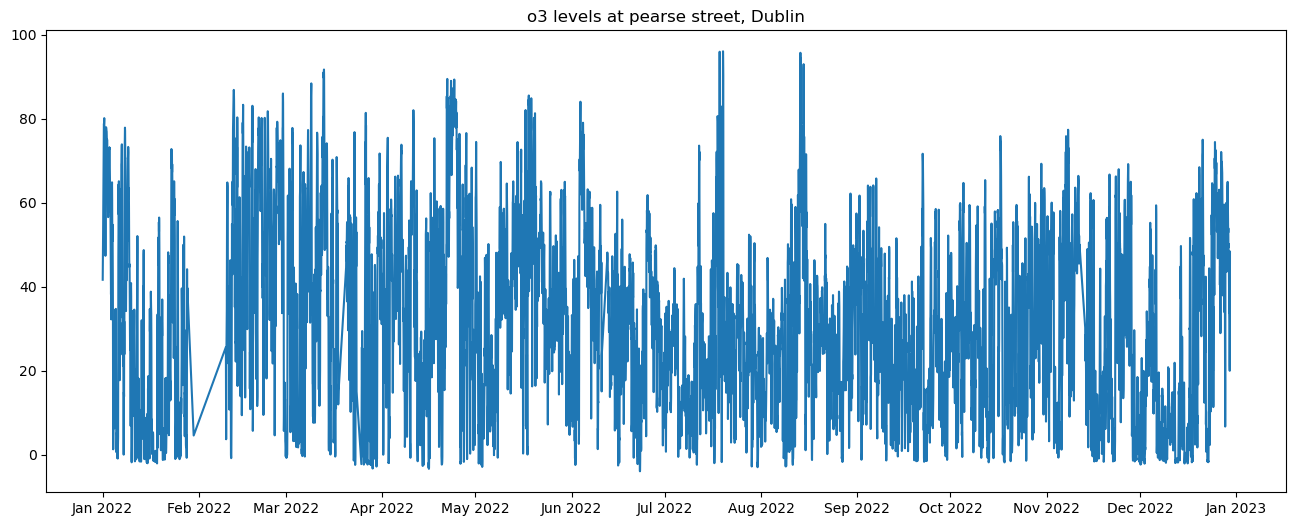

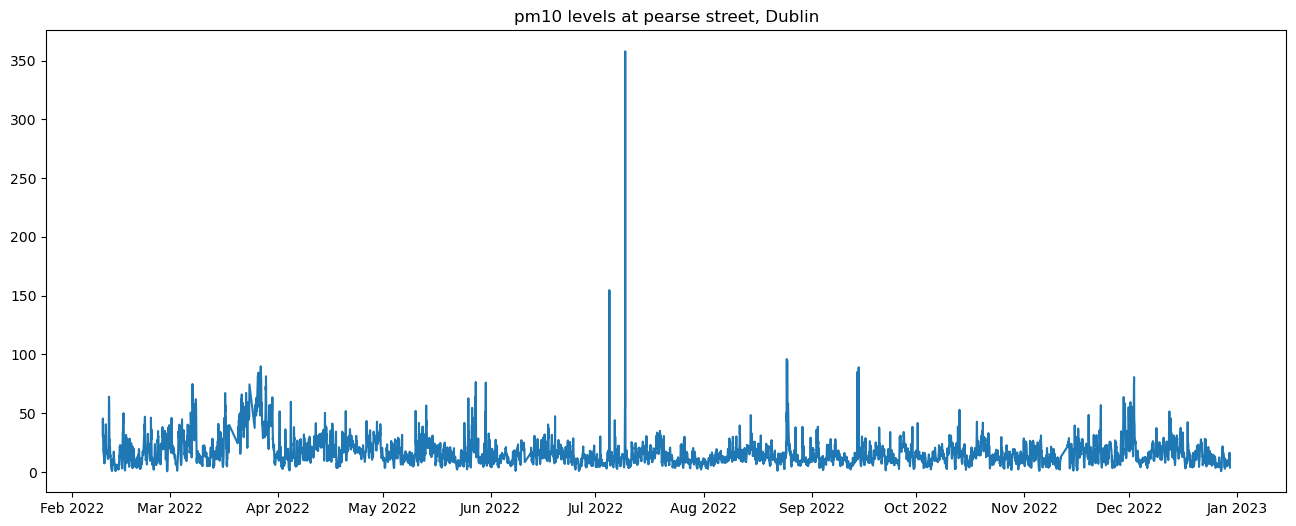

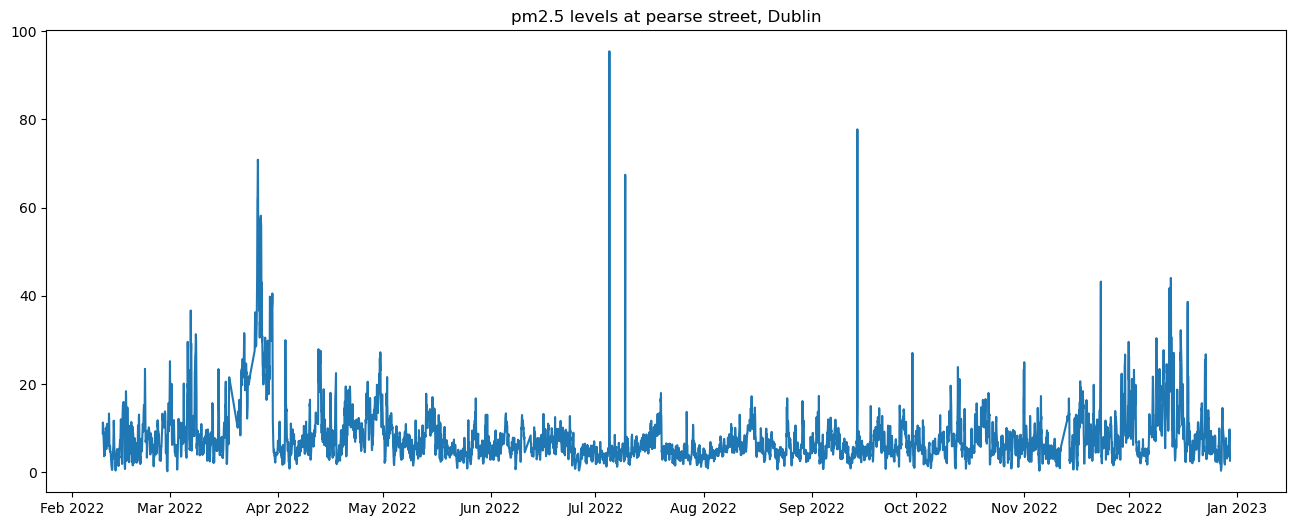

In [13]:
import matplotlib.dates as mdates

def plotline(dataset, col,fromtime, to, title):
    timeframe = dataset[(dataset['datetime'] >= fromtime)
                         & (dataset['datetime'] <= to)]

    plt.figure(figsize=(16, 6))
    sns.lineplot(data=timeframe, x='datetime', y=col)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(col +" " +title)

    date_formatter = mdates.DateFormatter('%b %Y')  # Format as abbreviated month and year (e.g., Jan 2022)
    desired_tick_frequency = mdates.MonthLocator()
    # Apply the tick frequency and formatter to the x-axis
    plt.gca().xaxis.set_major_locator(desired_tick_frequency)
    plt.gca().xaxis.set_major_formatter(date_formatter)
    
    #plt.legend()
    
    plt.show()
    

plotline(aqi_2022, 'no2', '2022-01-01', '2022-12-30', 'levels at pearse street, Dublin')
plotline(aqi_2022, 'o3', '2022-01-01', '2022-12-30', 'levels at pearse street, Dublin')
plotline(aqi_2022, 'pm10', '2022-01-01', '2022-12-30', 'levels at pearse street, Dublin')
plotline(aqi_2022, 'pm2.5', '2022-01-01', '2022-12-30', 'levels at pearse street, Dublin')

## Visualising densities

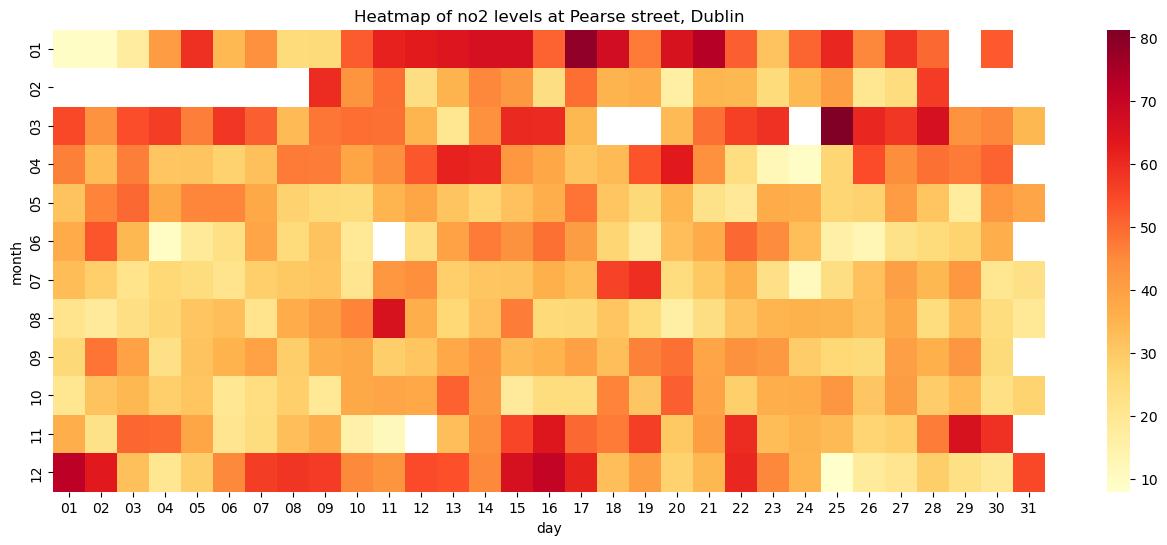

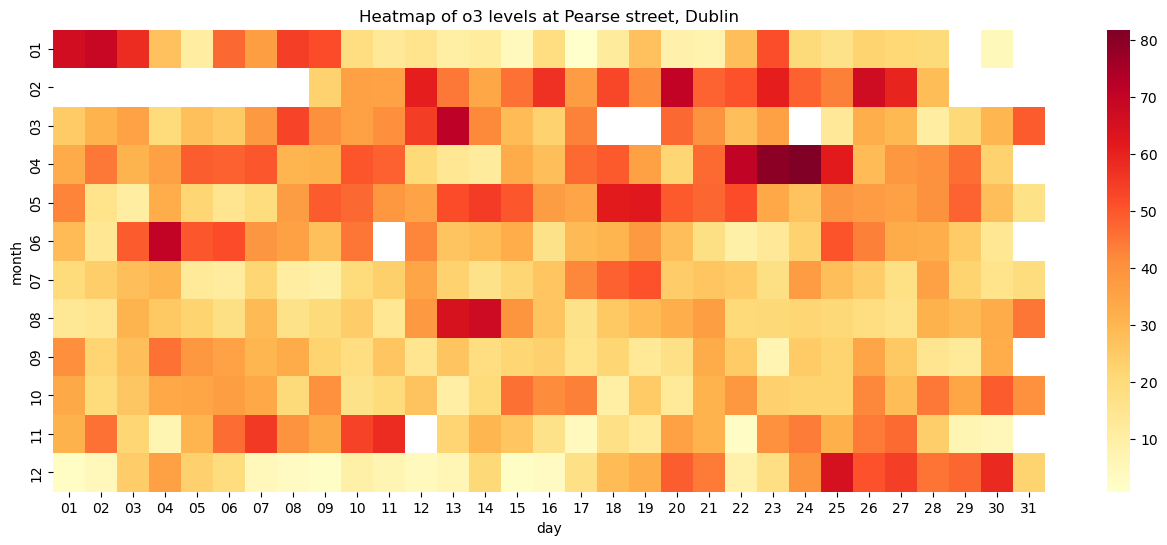

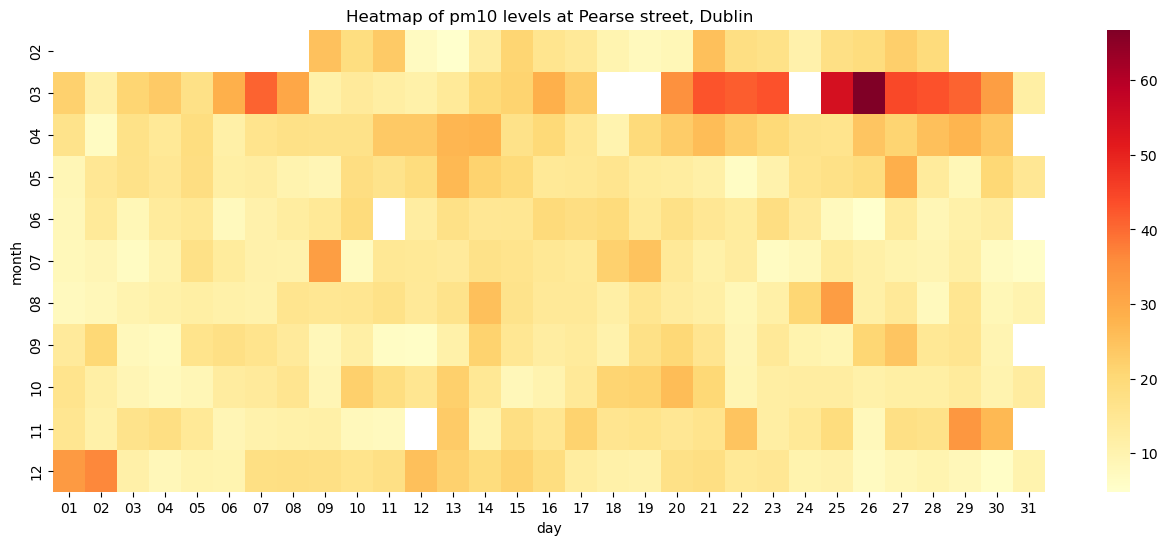

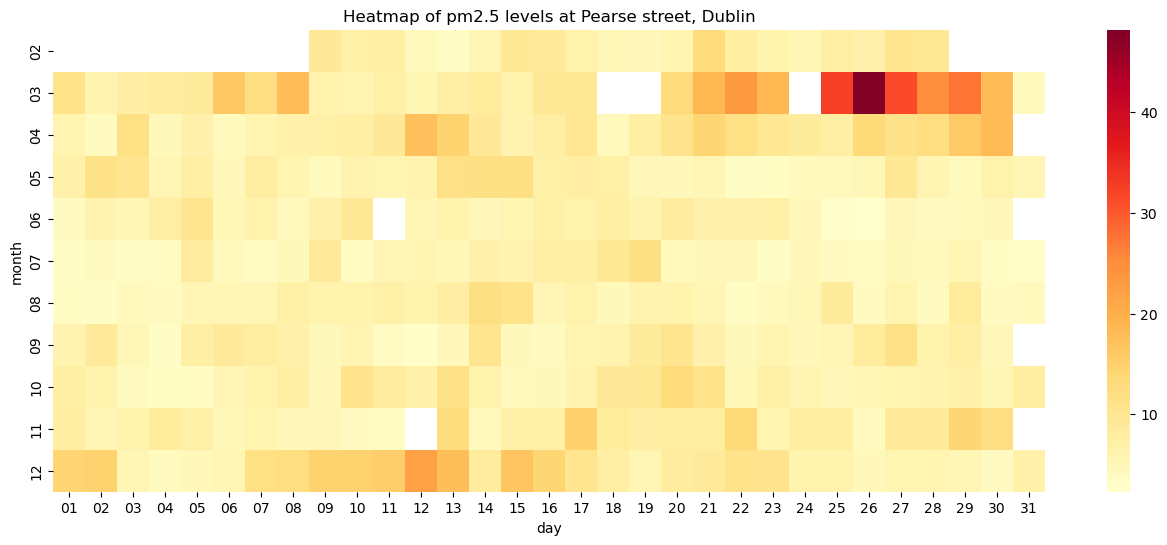

In [14]:
def plotheatmap(dataset, col, fromtime, to, title):
    dataset = dataset.reset_index()
    timeframe = dataset[(dataset['datetime'] >= fromtime)
                         & (dataset['datetime'] <= to)]
    
    timeframe.loc[:, 'month'] = timeframe['datetime'].dt.strftime('%m')
    timeframe.loc[:, 'day'] = timeframe['datetime'].dt.strftime('%d')
    
    timeframe_pm10 = timeframe.pivot_table(index = 'month',values=col, columns='day')
    #g = sns.FacetGrid(timeframe, col="month", col_wrap=2)
    
    #g.map_dataframe(lambda data, color: sns.heatmap(data=timeframe, cmap='YlOrRd'))
    plt.figure(figsize=(16, 6))
    sns.heatmap(data=timeframe_pm10, cmap='YlOrRd')
    
    plt.title("Heatmap of " +col + " " + title)
    plt.show()

plotheatmap(aqi_2022, 'no2', '2022-01-01', '2022-12-31', 'levels at Pearse street, Dublin')
plotheatmap(aqi_2022, 'o3', '2022-01-01', '2022-12-31', 'levels at Pearse street, Dublin')
plotheatmap(aqi_2022, 'pm10', '2022-01-01', '2022-12-31', 'levels at Pearse street, Dublin')
plotheatmap(aqi_2022, 'pm2.5', '2022-01-01', '2022-12-31', 'levels at Pearse street, Dublin')

## Visualising quantities

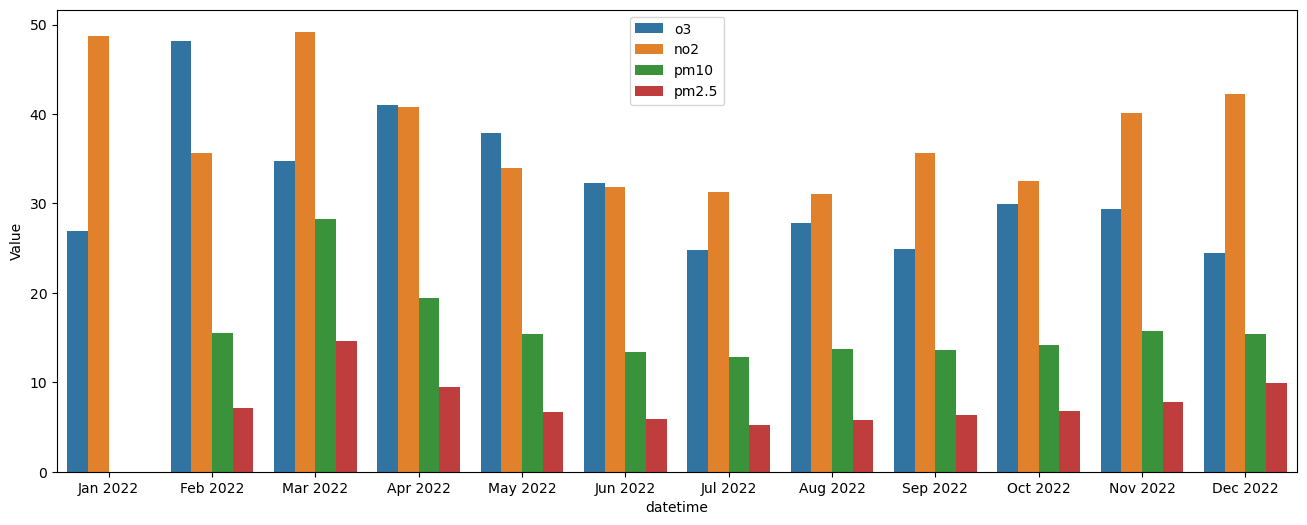

In [15]:
def plotbars(dataset, fromtime, to, title):
    timeframe = dataset[(dataset['datetime'] >= fromtime)
                         & (dataset['datetime'] <= to)]
    
    timeframe.set_index('datetime', inplace=True)
    
    timeframe = timeframe.resample('M').mean().reset_index()
    
    plt.figure(figsize=(16, 6))
    
    df_melted = pd.melt(timeframe, id_vars='datetime', value_vars=['o3', 'no2','pm10', 'pm2.5'], var_name='Pollutant', value_name='Value')

    # Create the grouped bar plot using seaborn
    sns.barplot(data=df_melted, x='datetime', y='Value', hue='Pollutant')

    plt.gca().xaxis.set_major_formatter(plt.FixedFormatter([date.strftime('%b %Y') for date in timeframe['datetime']]))

    plt.legend()
    
    plt.show()

plotbars(aqi_2022,'2022-01-01', '2022-12-31', 'AQI levels at Amiens street, Dublin')    


## Handling outliers and missing data


Making a copy of the original dataset so we don't overwrite changes

In [16]:
aqi_copy = aqi_2022.copy()

To handle outliers we use the **Inter Quartile range (IQR)** of column and define a **lower bound** and **upper bound**, finally we subset the dataset which falls between the defined range and **replace** them as **NaN**

In [17]:
def removeOutliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[col].loc[~((df[col] >= lower_bound) & (df[col] <= upper_bound))] = np.nan
    
    #df_altered = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

aqi_copy = removeOutliers(aqi_copy, 'no2')
aqi_copy = removeOutliers(aqi_copy, 'o3')
aqi_copy = removeOutliers(aqi_copy, 'pm10')
aqi_copy = removeOutliers(aqi_copy, 'pm2.5')

We have to see if there are missing days in dataset, so we can use pandas date range to create a new dataframe with entire year of 2022 and using the **difference** method we apply on our orriginal dataset to get the missing days

In [18]:
df = aqi_copy.set_index('datetime')
print("We have "+ str(len(
    pd.date_range(
        start = '2022-01-01',
        end = '2023-01-01',
        freq='1H')
    .difference(df.index)
)) + " rows of data missing")

We have 489 rows of data missing


To fill this data we first set the datetime column as index and reindex it using pandas date range, but we have want hourly data so we provide the **freq** parameter.

In [19]:
aqi_copy = (aqi_copy.set_index('datetime')
      .reindex(pd.date_range('2022-01-01', '2022-12-31', freq='1h'))
      .rename_axis(['datetime'])
      .fillna(np.nan)
      .reset_index())
aqi_copy = aqi_copy.drop(['index'], axis=1)
aqi_copy

,datetime,no2,o3,pm10,pm2.5
0,2022-01-01 00:00:00,14.53,41.67,NaN,NaN
1,2022-01-01 01:00:00,10.20,44.99,NaN,NaN
2,2022-01-01 02:00:00,7.72,49.98,NaN,NaN
3,2022-01-01 03:00:00,6.73,52.82,NaN,NaN
4,2022-01-01 04:00:00,2.87,57.84,NaN,NaN
...,...,...,...,...,...
8732,2022-12-30 20:00:00,35.05,34.99,13.28,9.70
8733,2022-12-30 21:00:00,30.21,36.48,13.47,10.17
8734,2022-12-30 22:00:00,31.43,39.81,11.46,8.54
8735,2022-12-30 23:00:00,34.96,36.22,11.95,7.72


Now that we have removed outliers and added all days required in dataset, we see now see how many total values are null to fill out.

In [20]:
aqi_copy.isna().sum()

datetime       0
no2          545
o3           495
pm10        1502
pm2.5       1621
dtype: int64

Instead of replacing the null values with entire column mean, we can replace by its respective month's mean. Creating a seperate dataframe which includes month-wise mean of every column will allow us to make things easier.

In [21]:
monthly_mean = aqi_copy.set_index('datetime')
monthly_mean = monthly_mean.resample('M').mean().reset_index()
monthly_mean['month'] = monthly_mean['datetime'].dt.strftime("%m")
monthly_mean

,datetime,no2,o3,pm10,pm2.5,month
0,2022-01-31,48.371849,26.871021,NaN,NaN,01
1,2022-02-28,35.108780,48.142987,14.095591,6.842958,02
2,2022-03-31,48.089590,34.748470,18.038363,7.432693,03
3,2022-04-30,40.794069,41.020278,18.652851,8.172554,04
4,2022-05-31,33.986910,37.838543,14.252006,6.553764,05
5,2022-06-30,31.847400,32.267430,13.287730,5.876691,06
6,2022-07-31,30.933676,24.785828,11.927598,4.969011,07
7,2022-08-31,31.101928,27.864284,12.847772,5.773127,08
8,2022-09-30,35.687278,24.875389,13.339566,6.212699,09
9,2022-10-31,32.550542,29.961840,13.815814,6.515422,10


**Incase of monthly mean being a NaN value, we take the entire column mean**

In [22]:
def fillMissingValues(row, df, col_name):
    datetime = row['datetime']
    row_val = row[col_name]
    if math.isnan(row_val):
        
        datarrow = df[df['month'] == datetime.strftime("%m")]
        
        [value] = datarrow[col_name].values
        if math.isnan(value):
            row_val = aqi_copy[col_name].mean()
        else:
            row_val = value

    return row_val

aqi_copy['no2'] = aqi_copy.apply(lambda x: fillMissingValues(x, monthly_mean, 'no2'), axis = 1)
aqi_copy['o3'] = aqi_copy.apply(lambda x: fillMissingValues(x, monthly_mean, 'o3'), axis = 1)
aqi_copy['pm10'] = aqi_copy.apply(lambda x: fillMissingValues(x, monthly_mean, 'pm10'), axis = 1)
aqi_copy['pm2.5'] = aqi_copy.apply(lambda x: fillMissingValues(x, monthly_mean, 'pm2.5'), axis = 1)

In [23]:
aqi_copy.isna().sum()

datetime    0
no2         0
o3          0
pm10        0
pm2.5       0
dtype: int64

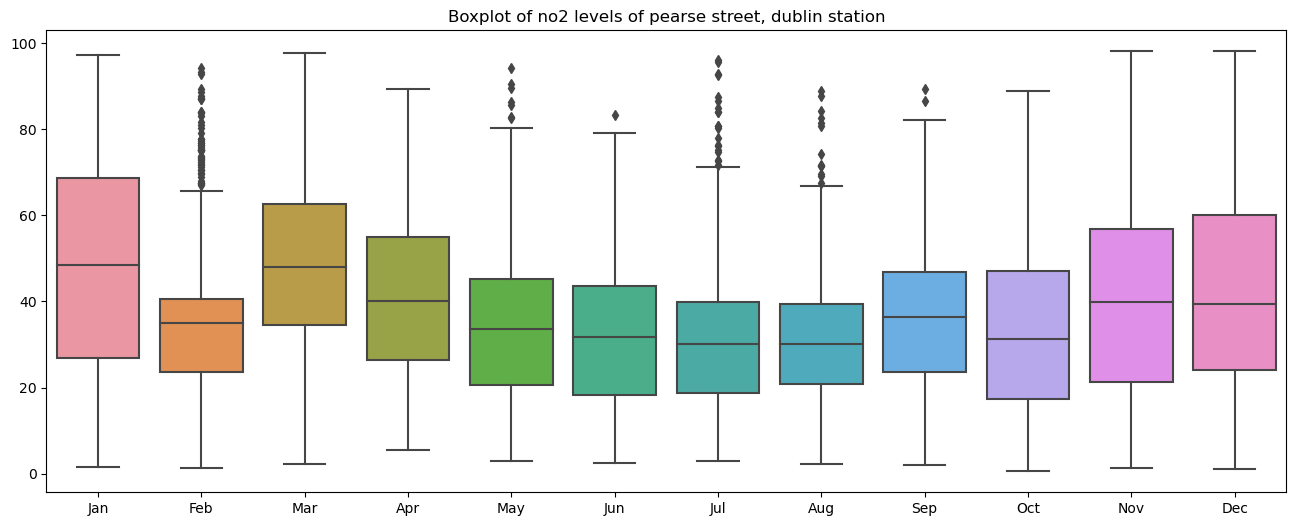

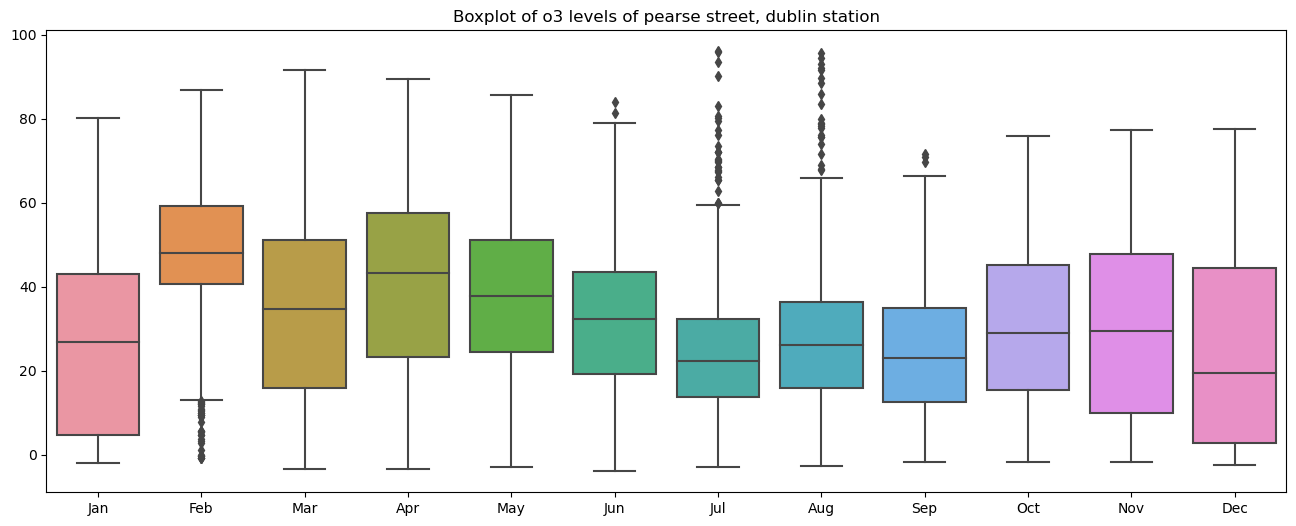

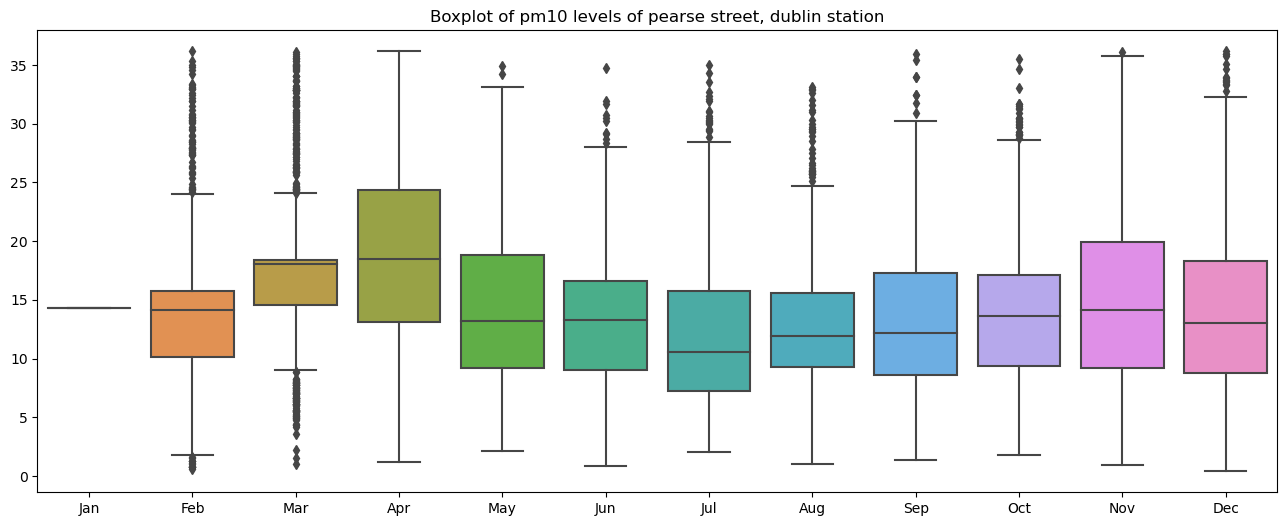

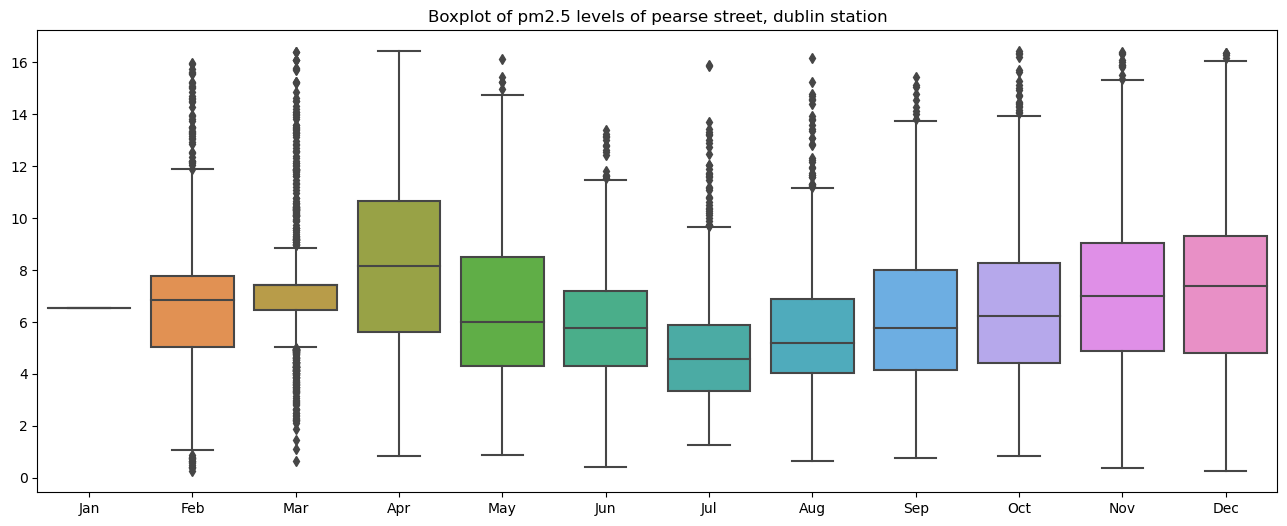

In [24]:
plotbox(aqi_copy, 'no2','2022-01-01', '2022-12-31')
plotbox(aqi_copy, 'o3','2022-01-01', '2022-12-31')
plotbox(aqi_copy, 'pm10','2022-01-01', '2022-12-31')   
plotbox(aqi_copy, 'pm2.5','2022-01-01', '2022-12-31')   

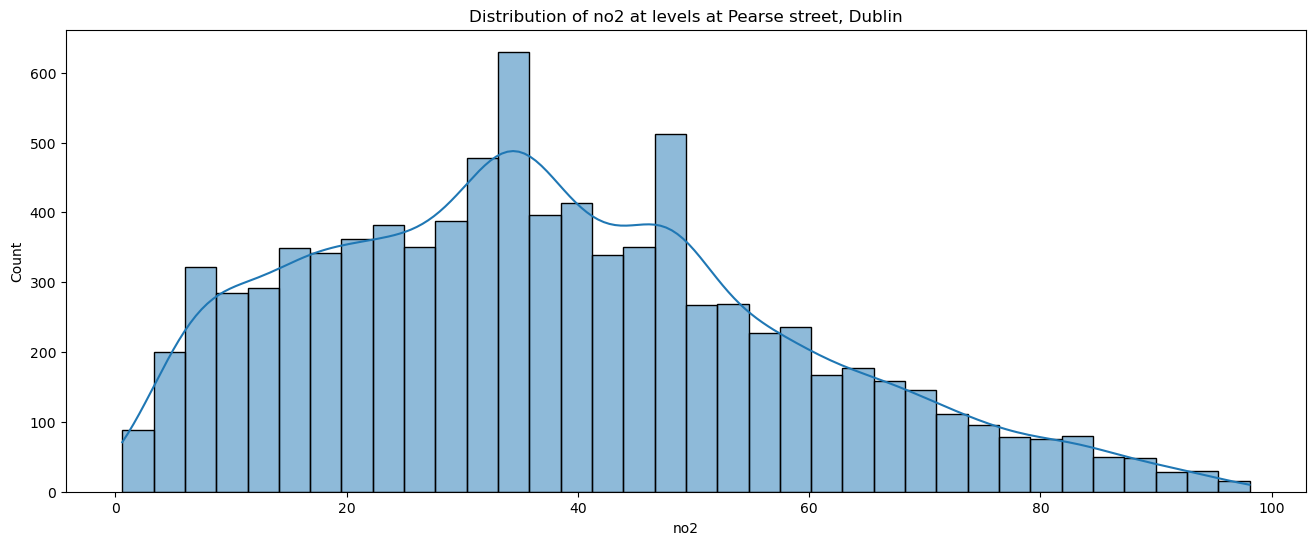

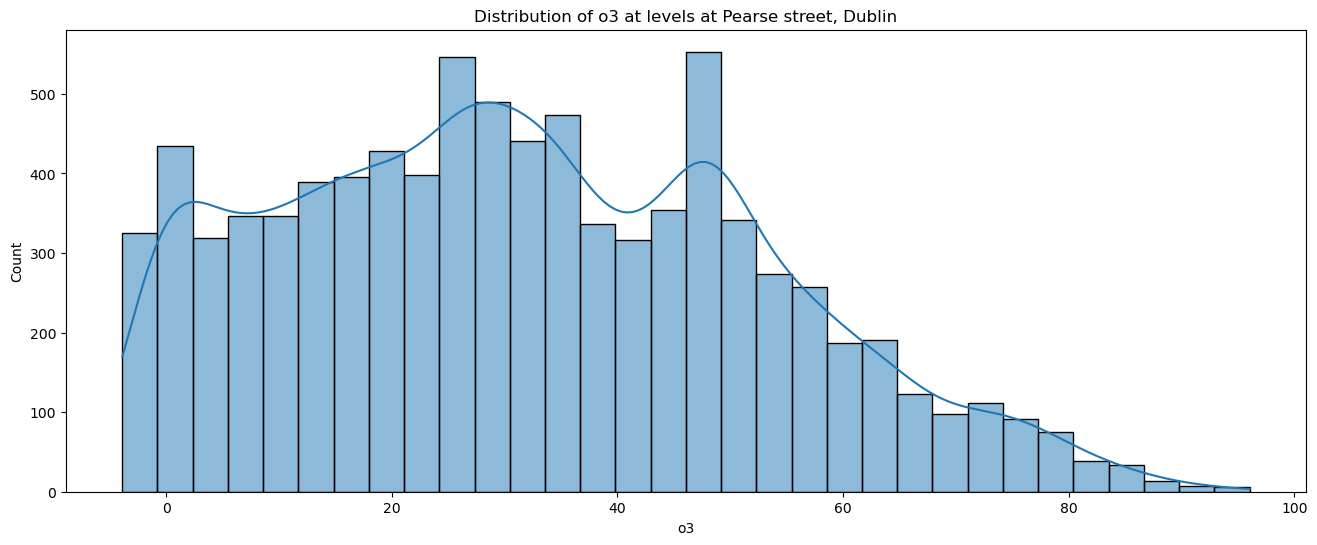

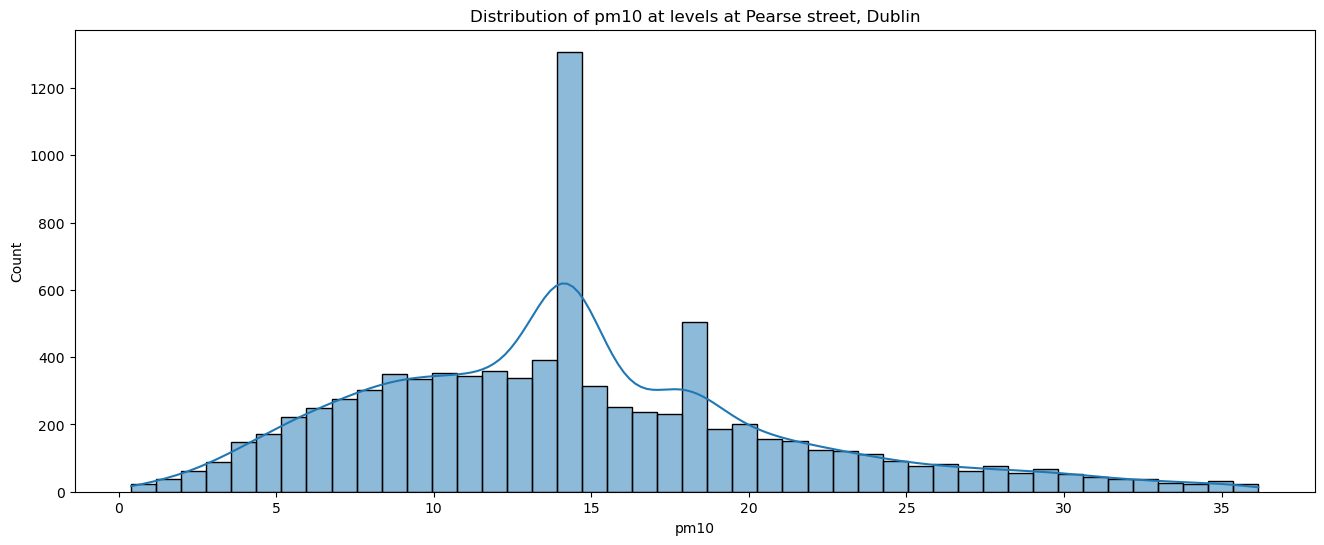

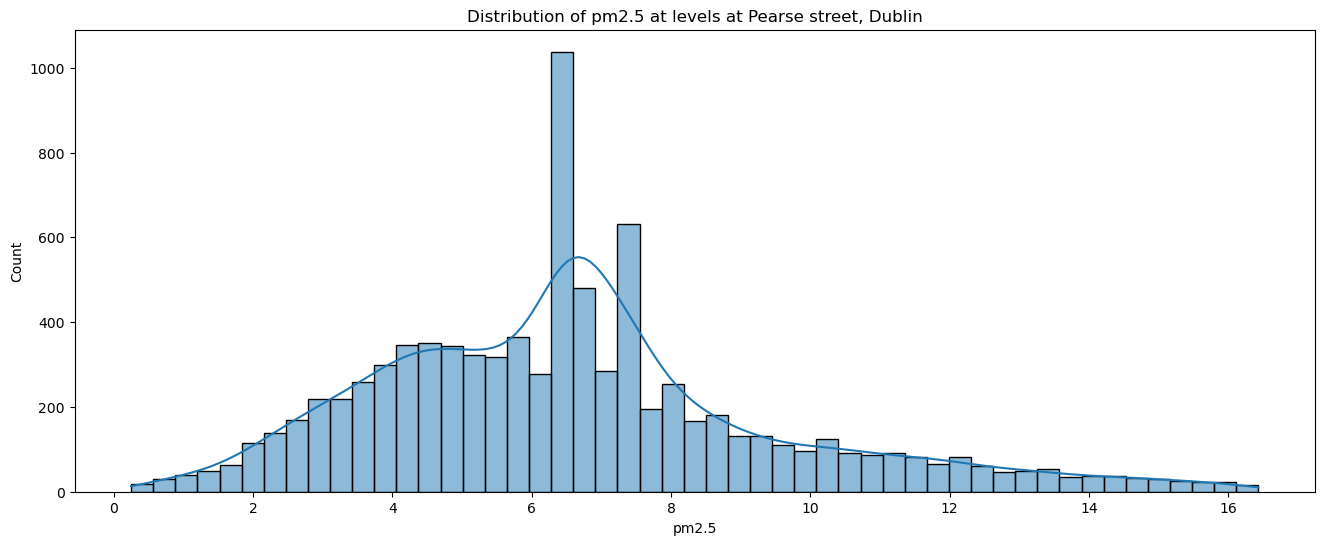

In [34]:
plothistogram(aqi_copy, 'no2', '2022-01-01', '2022-12-31',  'Pearse street, Dublin')
plothistogram(aqi_copy, 'o3', '2022-01-01', '2022-12-31', 'Pearse street, Dublin')
plothistogram(aqi_copy, 'pm10', '2022-01-01', '2022-12-31', 'Pearse street, Dublin')
plothistogram(aqi_copy, 'pm2.5', '2022-01-01', '2022-12-31', 'Pearse street, Dublin')

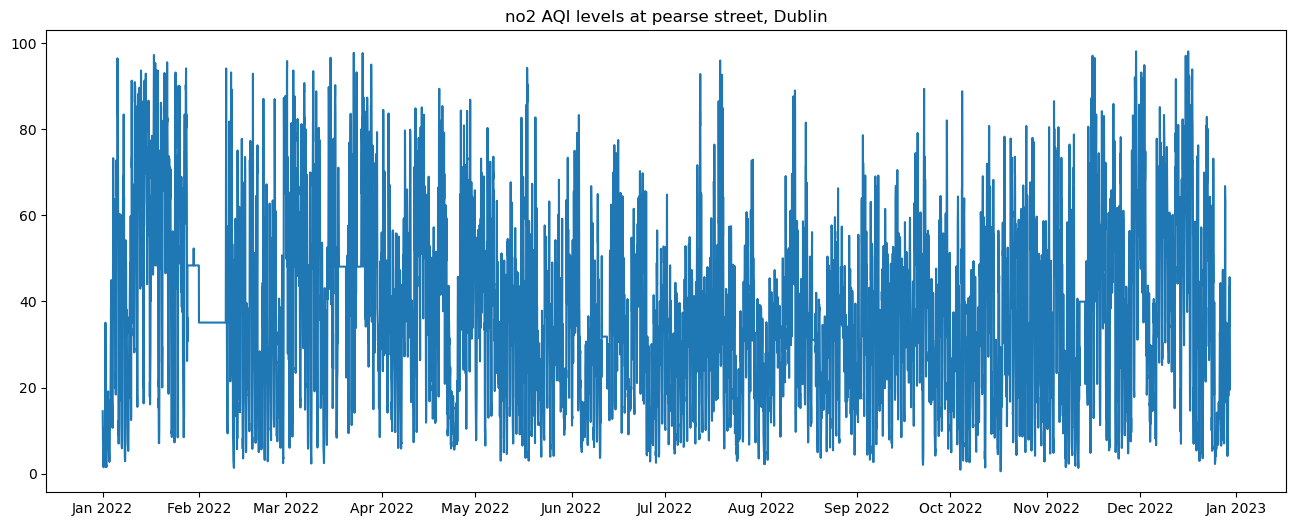

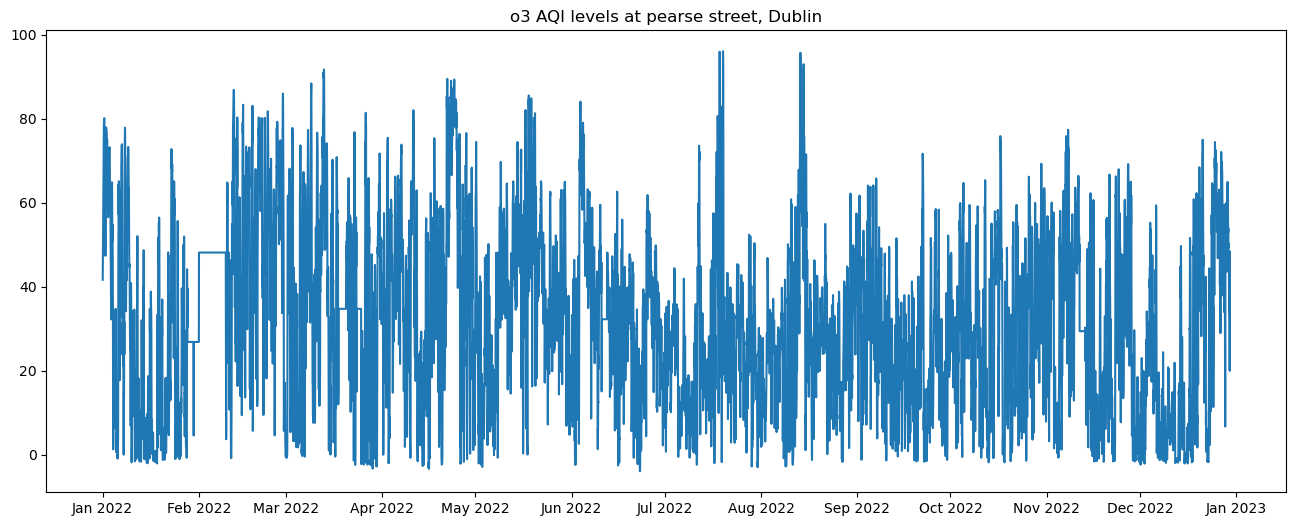

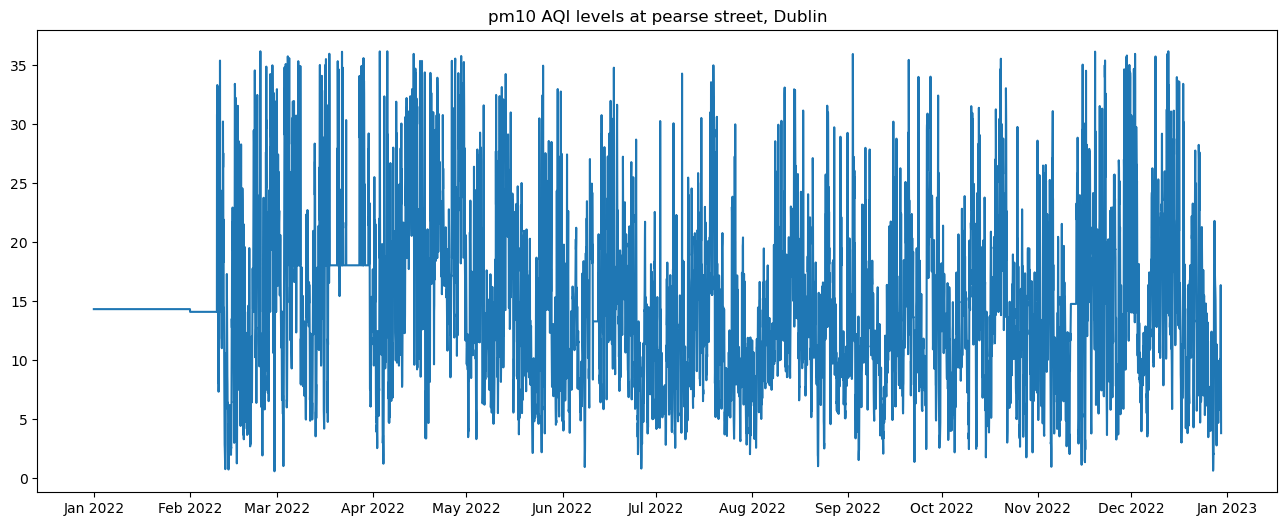

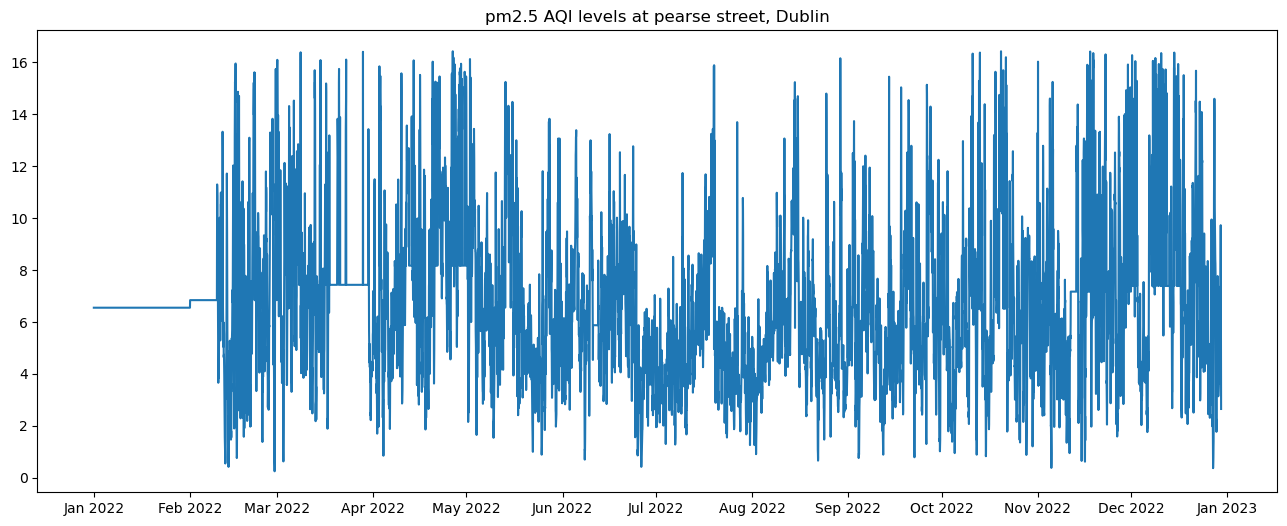

In [26]:
plotline(aqi_copy, 'no2', '2022-01-01', '2022-12-30', 'AQI levels at pearse street, Dublin')
plotline(aqi_copy, 'o3', '2022-01-01', '2022-12-30', 'AQI levels at pearse street, Dublin')
plotline(aqi_copy, 'pm10', '2022-01-01', '2022-12-30', 'AQI levels at pearse street, Dublin')
plotline(aqi_copy, 'pm2.5', '2022-01-01', '2022-12-30', 'AQI levels at pearse street, Dublin')

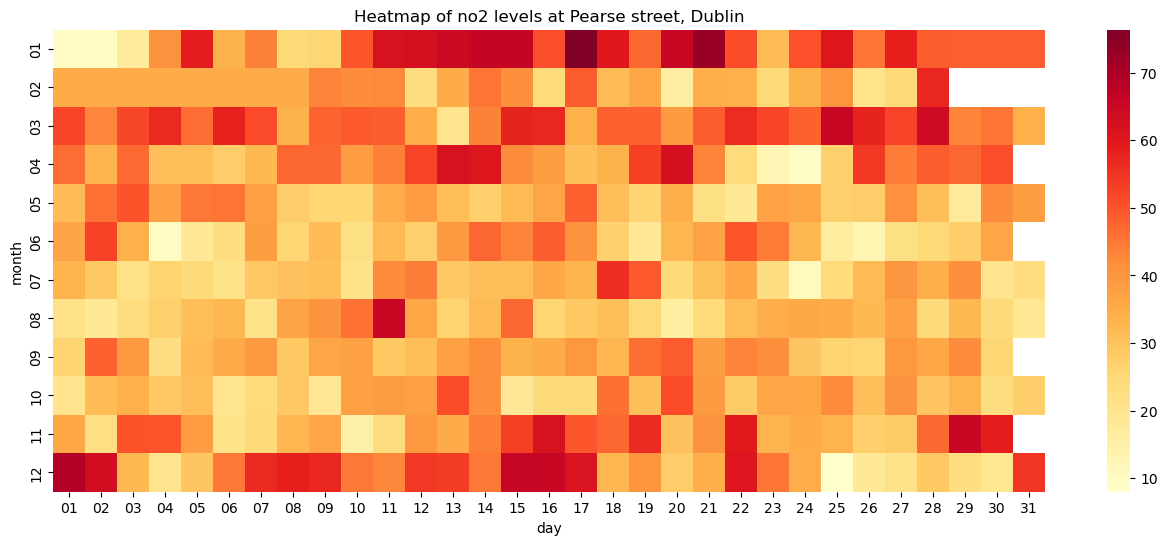

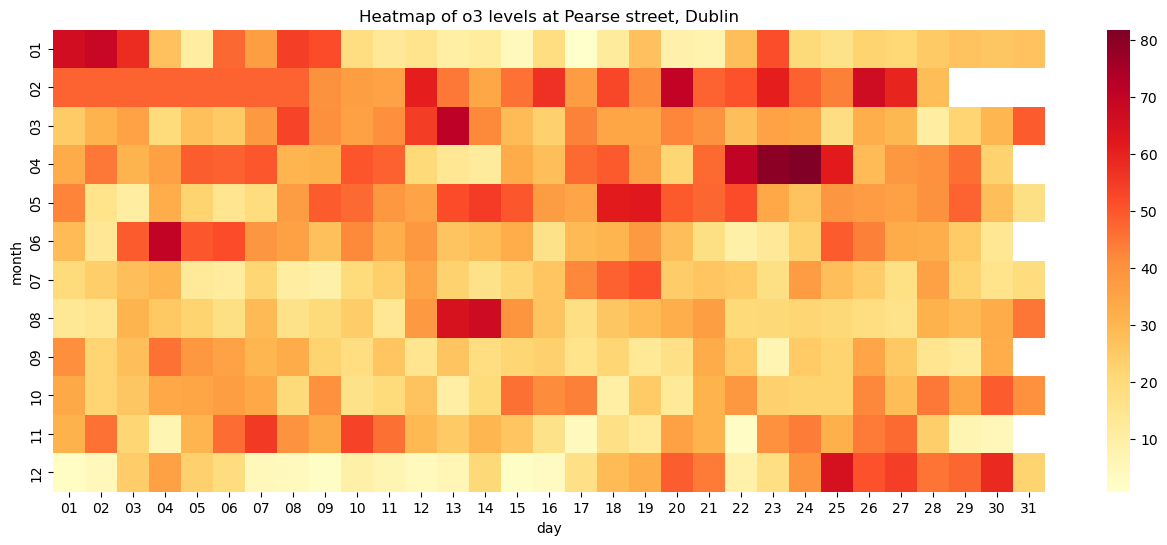

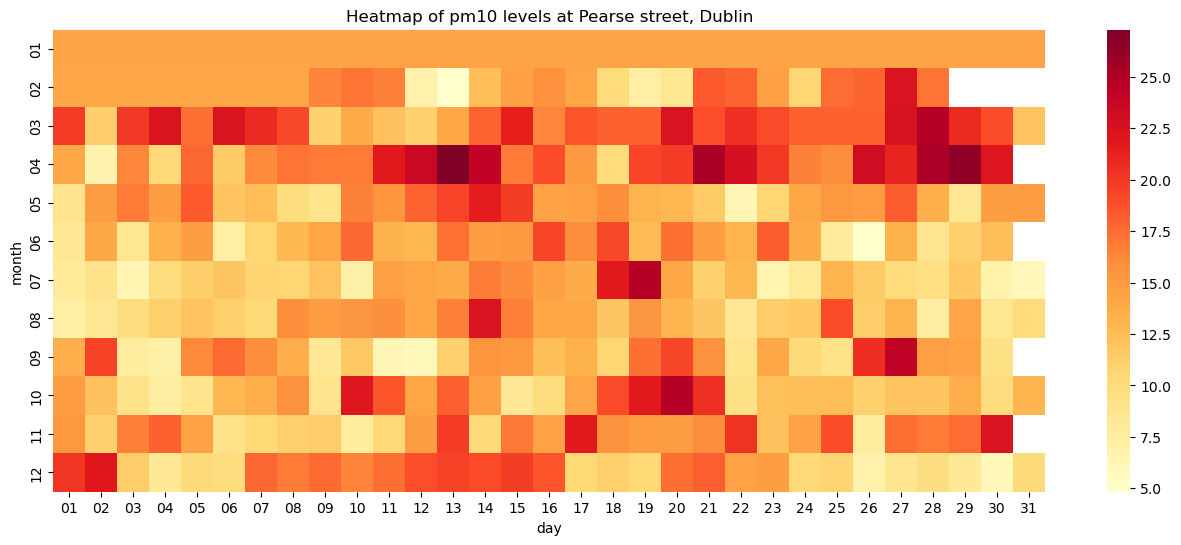

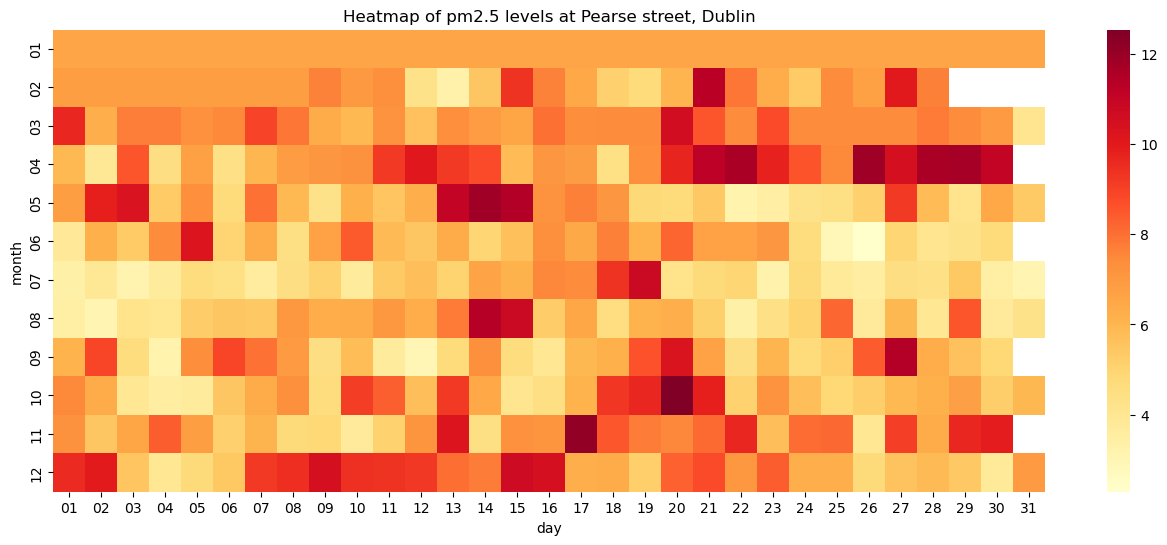

In [27]:
plotheatmap(aqi_copy, 'no2', '2022-01-01', '2022-12-31', 'levels at Pearse street, Dublin')
plotheatmap(aqi_copy, 'o3', '2022-01-01', '2022-12-31', 'levels at Pearse street, Dublin')
plotheatmap(aqi_copy, 'pm10', '2022-01-01', '2022-12-31', 'levels at Pearse street, Dublin')
plotheatmap(aqi_copy, 'pm2.5', '2022-01-01', '2022-12-31', 'levels at Pearse street, Dublin')

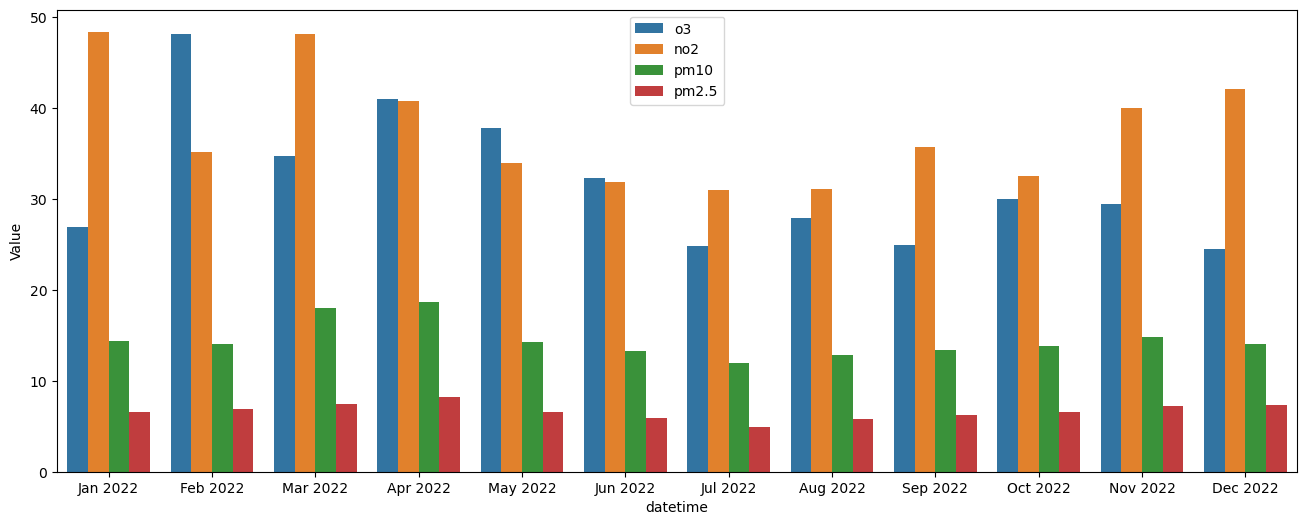

In [28]:
plotbars(aqi_copy,'2022-01-01', '2022-12-31', 'AQI levels at Pearse street, Dublin')    

In [29]:
aqi_copy

,datetime,no2,o3,pm10,pm2.5
0,2022-01-01 00:00:00,14.53,41.67,14.325952,6.551401
1,2022-01-01 01:00:00,10.20,44.99,14.325952,6.551401
2,2022-01-01 02:00:00,7.72,49.98,14.325952,6.551401
3,2022-01-01 03:00:00,6.73,52.82,14.325952,6.551401
4,2022-01-01 04:00:00,2.87,57.84,14.325952,6.551401
...,...,...,...,...,...
8732,2022-12-30 20:00:00,35.05,34.99,13.280000,9.700000
8733,2022-12-30 21:00:00,30.21,36.48,13.470000,10.170000
8734,2022-12-30 22:00:00,31.43,39.81,11.460000,8.540000
8735,2022-12-30 23:00:00,34.96,36.22,11.950000,7.720000


## Combining datasets

Now we combine our cleaned air quality data with meteorological data

In [30]:
met_2022 = pd.read_csv('../data/meterology/met_2022.csv')

In [31]:
met_2022

,Unnamed: 0,datetime,rain,temp,wetb,dewpt,vappr,rhum,msl
0,161111,2022-01-01 00:00:00,0.0,13.1,11.4,9.8,12.1,80.0,1007.3
1,161112,2022-01-01 01:00:00,0.0,13.9,11.2,8.5,11.1,70.0,1005.8
2,161113,2022-01-01 02:00:00,0.0,14.0,11.0,8.1,10.8,67.0,1005.0
3,161114,2022-01-01 03:00:00,0.0,14.6,11.4,8.4,11.0,66.0,1003.9
4,161115,2022-01-01 04:00:00,0.0,14.9,12.1,9.5,11.9,70.0,1002.7
...,...,...,...,...,...,...,...,...,...
8732,169843,2022-12-30 20:00:00,0.0,7.4,6.6,5.5,9.0,87.0,989.8
8733,169844,2022-12-30 21:00:00,0.1,7.2,6.2,4.8,8.6,84.0,990.1
8734,169845,2022-12-30 22:00:00,0.0,7.3,6.1,4.5,8.4,82.0,990.4
8735,169846,2022-12-30 23:00:00,0.0,7.5,6.4,4.9,8.7,83.0,990.6


In [32]:
pearse_street = pd.concat([met_2022[['rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']],aqi_copy], axis=1)

In [33]:
pearse_street[['datetime', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'no2', 'o3', 'pm10', 'pm2.5']].to_csv('../data/pearse_street/pearse_street.csv')